# Principal Component Analysis (PCA)

El análisis de los componentes principales (o Principal Component Analysis (PCA)) de un conjunto de datos es una secuencia de vectores unitarios, donde cada *i-esimo* vector es la dirección de la recta que mejor se ajusta a la data siendo ortogonal a los primeros *i-esimo -1* vectores. En este caso, la línea que mejor se ajusta a la data es aquella que minimiza la distancia euclideana entre los puntos y la recta. Estas direcciones constituyen una base ortonormal en donde las distintas dimensiones de la data no están correlacionadas linealmente.

### Mathematical foundamentals

Este análisis calcula los componentes principales y los usa para realizar un cambio de base o un cambio de coordenadas a la data, y en algunos casos, tomando solamente los primeros componentes principales del cambio de base para hacer una reducción de la dimensionalidad (Dimensionality reduction).

- El PCA se puede pensar como el ajuste de un elipsoide *p-dimensional* a los datos, donde cada eje del elipsoide representa un componente principal. Si algun eje del elipsoide es pequeño, entonces la varianza a lo largo de ese eje tambien es pequeña. 

- Para encontrar los ejes del elipsoide, primero debemos centrar los valores de cada feature en 0 restando la media de cada feature a la data. 
- A continuación, calculamos la matriz de covarianza de la data para luego extraer los autovectores y autovalores de dicha matriz. 
- Luego, se normalizan los autovectores para tener una base ortonormal, donde cada vector de esta base ortonormal seran los ejes del elopsoide. 
- Con este cambio de coordenadas o base, la matriz de covarianza se convierte en una matriz diagonal, donde cada elemento de la diagonal principal representa la varianza de cada eje. 
- La proporción de la varianza que representa cada autovector puede calcularse dividiendo su autovalor asociado por la suma de todos los autovalores.

A continuación, se deja una animación con los nuevos ejes centrados en la media de la data. Los componentes principales serán aquellos que tengan el menor error posible y que se ajusten mejor a la data, siendo estos dos ejes ortogonales entre si. La primera componente principal es la mas larga, ya que contiene mayor varianza.

<img src="images/PCA.gif" width="1000" align="center">

### Applications

- **Dimensionality reduction**: Cuando las features son altamente redundantes (multicoliniales), PCA separará la redundancia en componentes de varianza cercana a 0, las cuales se pueden ignorar ya que contendran poca información. (La varianza es otra forma de expresar la cantidad de información de una feature, cuando hay poca varianza, significa que los datos no varían mucho de su media, por lo tanto no aportan mucha información, en cambio, si hay mucha varianza, significa que los datos se dispersan mas, por consecuente, hay mas información)

- **Anomaly detection**: Las variaciones inusuales, suelen aparecen en las componentes de baja varianza. Dichas componentes pueden ser muy informativas en casos de detección de anomalías o outliers.

- **Noise reduction**: En una serie de mediciones, las mismas compartiran algo de ruido de fondo. PCA puede tomar la información mas importante en un grupo reducido de features, mientras que el ruido queda aislado, ya que no aporta información al estar en todas las mediciones, pudiendo así incrementar la relación señal a ruido.

##### Ejemplo: Automobile 1985 dataset

Para aplicar lo mencionado, analizaremos el dataset de autos de 1985, usando PCA de forma descriptiva para descubrir nuevas features

In [59]:
### Dataset loading

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.feature_selection import mutual_info_regression


plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

df = pd.read_csv('datasets/automobile_1985_dataset.csv')

Para reducir la dimensionalidad de la data, se seleccionan solamente 4 features, las cuales tienen algo MI con la target `price`

In [60]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

features = ["highway_mpg", "engine_size", "horsepower", "curb_weight"]

X = df.copy()
y = X.pop('price')
X = X.loc[:, features]

print(make_mi_scores(X, y, discrete_features = False))

curb_weight    0.833756
highway_mpg    0.656495
horsepower     0.551971
engine_size    0.536743
Name: MI Scores, dtype: float64


Ahora, se utiliza `X` para entrenar el estimador de PCA. Antes de eso, se debe estandarizar la data para centrar los ejes originales en la media de la data.

In [61]:
from sklearn.decomposition import PCA

# Standardize
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4
0,0.382486,-0.400222,0.124122,0.169539
1,0.382486,-0.400222,0.124122,0.169539
2,1.550890,-0.107175,0.598361,-0.256081
3,-0.408859,-0.425947,0.243335,0.013920
4,1.132749,-0.814565,-0.202885,0.224138


Los valores que muestra `X_pca` son los valores de las proyecciones de la data original sobre los nuevos componentes principales. Para ver la matriz que transforma los datos, se hace con el método `pca.components_`

In [62]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4
highway_mpg,-0.492347,0.770892,0.070142,-0.397996
engine_size,0.503859,0.626709,0.019960,0.594107
horsepower,0.500448,0.013788,0.731093,-0.463534
curb_weight,0.503262,0.113008,-0.678369,-0.523232


Para comprobar los fundamentos matematicos, podemos analizar si las componentes principales son ortogonales entre si y las mismas conforman una base ortonormal.

Para ello, si $PC_{mtx}$ es la matriz donde en cada columne se encuentra cada componente principal (los autovectores), entonces para comprobar que las columnas son ortogonales entre si el producto de $PC_{mtx}^T$ con $PC_{mtx}$ tiene que dar una matriz diagonal. Por otro lado, si los autovectores están normalizados, y los mismos conforman una base ortonormal, dicha multiplicación tiene que dar la matriz diagonal.

$$
PC_{mtx}^T \cdot PC_{mtx} = I
$$

In [72]:
PC_mtx = loadings.to_numpy()
print(np.abs(np.matmul(PC_mtx.T, PC_mtx).round(2)))

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


A su vez, se puede ver como se distribuye la varianza entre las componentes principales

array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

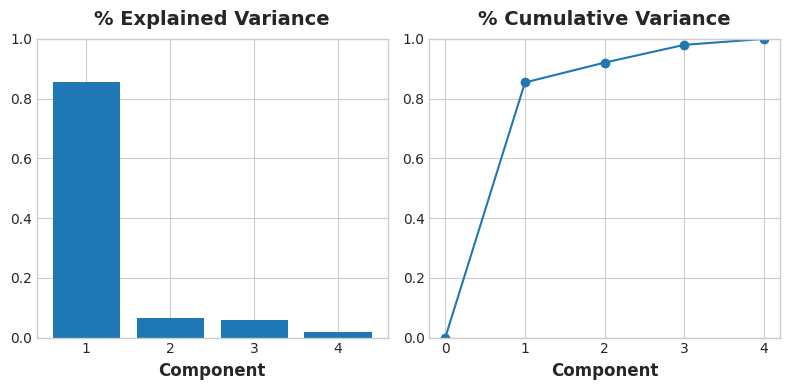

In [43]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

plot_variance(pca)

Tambien podemos hallar la MI de estas componentes con la target `price`. Donde se puede ver que la primer componente principal es la que mayor información mútua tiene con la target.

In [44]:
mi_scores = make_mi_scores(X_pca, y, discrete_features=False)
mi_scores

PC1    1.015127
PC2    0.378757
PC3    0.307075
PC4    0.205027
Name: MI Scores, dtype: float64

(-2.0, 2.0)

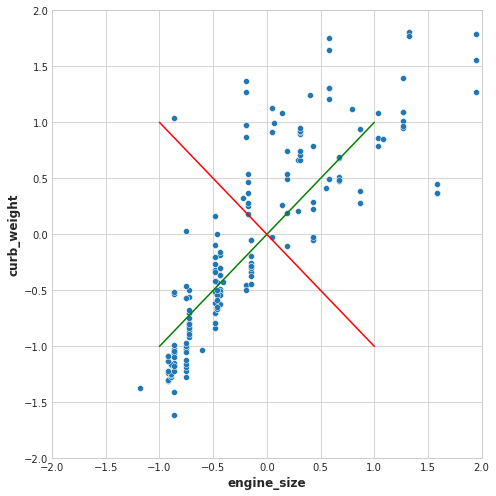

In [56]:
features = ["highway_mpg", "engine_size", "horsepower", "curb_weight"]

feature1 = features[1]
feature2 = features[3]

X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

X_scaled = X_scaled[[feature1,feature2]]

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X_scaled.columns,  # and the rows are the original features
)


x = np.linspace(-1,1,100)

pc1 = loadings['PC1'].to_numpy()
pc1_ax = pc1[0]/pc1[1] * x

pc2 = loadings['PC2'].to_numpy()
pc2_ax = pc2[0]/pc2[1] * x

plt.figure(figsize=(7,7))
plt.plot(x,pc1_ax, color = 'green')
plt.plot(x,pc2_ax, color = 'red')
sns.scatterplot(x = X_scaled[feature1], y = X_scaled[feature2])
plt.xlim([-2,2])
plt.ylim([-2,2])